# Unsteady convection + reaction 1D

Reaction: $A \rightarrow B\rightarrow C$

$\frac{\partial c_A}{\partial t} + \mathrm{div}(v \, c_A) = -k_1 \, c_A$

$\frac{\partial c_B}{\partial t} + \mathrm{div}(v \, c_B) = k_1 \, c_A - k_2 \, c_B$

$\frac{\partial c_C}{\partial t} + \mathrm{div}(v \, c_C) = k_2 \, c_B$

with boundary conditions: $c_A(0)=0.5, c_B(0)=c_C(0)=0$, $\frac{\partial c_i(L)}{\partial x} = 0$

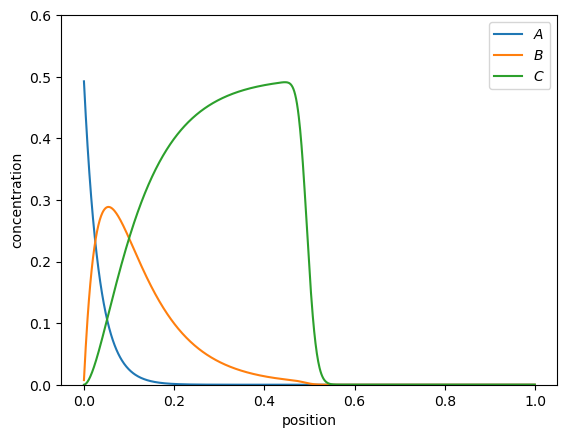

In [2]:
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from pymrm import construct_convflux_upwind, construct_div, NumJac, interp_cntr_to_stagg_tvd, minmod

def reaction(c, k_1, k_2):
    r = np.zeros_like(c)
    r[:,0] = -k_1*c[:,0]
    r[:,1] = k_1*c[:,0] - k_2*c[:,1]
    r[:,2] = k_2*c[:,1]
    return r

L = 1 
v = 0.1
k_1 = 3.0
k_2 = 1.0
t_end = 5
bc = ({'a': 0, 'b': 1, 'd':[[0.5, 0, 0]]}, {'a': 1, 'b': 0, 'd':0})

num_x = 1000
num_c = 3
num_time_steps = 1000
num_inner_iter = 1
output_interval = 10
dt = t_end / num_time_steps
c = np.zeros((num_x, num_c))
numjac = NumJac(c.shape, axes_blocks = [-1])

x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

Conv, conv_bc = construct_convflux_upwind(c.shape, x_f, x_c, bc, v, axis=0)
Div = construct_div(c.shape, x_f, nu=0, axis=0)
g_const = (Div @ conv_bc)
f_react, Jac_react = numjac(lambda c: reaction(c, k_1, k_2), c)
Jac = sp.sparse.eye(c.size, format='csc')/dt + Div @ Conv - Jac_react
Jac_lu = sla.splu(Jac)

fig, ax = plt.subplots()
labels = [r'$A$',r'$B$',r'$C$']
lines = [ax.plot(x_c, c[:, j], label=labels[j])[0] for j in range(num_c)]
plt.legend()
plt.xlabel('position')
plt.ylabel('concentration')
plt.ylim(0,0.6)
for i in range(num_time_steps):
    c_old = c.copy().reshape(-1,1)
    for j in range(num_inner_iter):
        c_f, dc_f = interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, minmod, axis=0)
        g_conv_deferred = Div @ (v*dc_f).reshape((-1,1))
        g = g_const + Jac @ c.reshape(-1,1) - c_old/dt + g_conv_deferred
        c -= Jac_lu.solve(g).reshape(c.shape)
    clear_output(wait=True)
    if (i % output_interval == 0):
        for j in range(num_c):
            lines[j].set_ydata(c[:, j])
        display(fig)